In [1]:
import pandas as pd

import numpy as np

import h5py

import glob

import matplotlib.pyplot as plt

%matplotlib inline

import tensorflow as tf


In [11]:
import tensorflow as tf
import os
from tensorflow.keras import layers, models
import tensorflow_io as tfio
EPOCHS =5

import tensorflow as tf
import os

# Define paths to image and label folders
image_dir = "/Users/frankconway/Library/CloudStorage/OneDrive-Personal/Strathclyde/Strathclyde/Year5/EE581/Project/EE581/data/png/img"
label_dir = "/Users/frankconway/Library/CloudStorage/OneDrive-Personal/Strathclyde/Strathclyde/Year5/EE581/Project/EE581/data/png/label"

# Get sorted file paths
image_paths = sorted([os.path.join(image_dir, fname) for fname in os.listdir(image_dir)])
label_paths = sorted([os.path.join(label_dir, fname) for fname in os.listdir(label_dir)])

# Function to load and preprocess images
def load_image(image_path, label_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)  # Change to 1 for grayscale
    image = tf.image.resize(image, (256, 256))  # Resize to match your model input
    image = tf.cast(image, tf.float32) / 255.0  # Normalize

    label = tf.io.read_file(label_path)
    label = tf.image.decode_png(label, channels=1)  # Change channels based on label format
    label = tf.image.resize(label, (256, 256), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    label = tf.cast(label, tf.uint8)  # Keep as uint8 for categorical labels

    return image, label

# Create a dataset from file paths
dataset = tf.data.Dataset.from_tensor_slices((image_paths, label_paths))
dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(buffer_size=1000)  # Adjust buffer size
dataset = dataset.batch(16)  # Adjust batch size based on GPU memory
dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Optimize performance

# Split into training and validation
train_size = int(0.8 * len(image_paths))
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size)


## UNET MODEL

In [12]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Custom Metrics
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

# Define UNet Model
def unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS):
    inputs = tf.keras.layers.Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))

    # Contracting Path
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = tf.keras.layers.Dropout(0.1)(c1)
    c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = tf.keras.layers.Dropout(0.1)(c2)
    c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = tf.keras.layers.Dropout(0.2)(c3)
    c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = tf.keras.layers.Dropout(0.2)(c4)
    c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = tf.keras.layers.Dropout(0.3)(c5)
    c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Expanding Path
    u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = tf.keras.layers.Dropout(0.2)(c6)
    c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = tf.keras.layers.Dropout(0.2)(c7)
    c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = tf.keras.layers.Dropout(0.1)(c8)
    c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

    u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = tf.keras.layers.Dropout(0.1)(c9)
    c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)

    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', f1_m, precision_m, recall_m])

    return model

# Example Usage
IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS = 256, 256, 3


model = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train model with dataset
history = model.fit(dataset, epochs=EPOCHS)

# Define training and validation data (ensure data is preprocessed and normalized)
# x_train, y_train, x_valid, y_valid = ... (Load your datasets)

# # Initialize and compile the model
# model = unet_model(IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS)

# # Define Callbacks
# checkpointer = tf.keras.callbacks.ModelCheckpoint(
#     "best_model.keras", monitor="val_f1_m", verbose=1, save_best_only=True, mode="max"
# )
# earlyStopping = tf.keras.callbacks.EarlyStopping(
#     monitor="val_f1_m", patience=10, verbose=1, mode="max"
# )

# callbacks = [earlyStopping, checkpointer]

# # Train the model
# history = model.fit(
#     train_dataset, batch_size=16, epochs=100, verbose=2,
#     validation_data=val_dataset, callbacks=callbacks
# )

# # Save the final model
# model.save("model_save.keras")

# Evaluate the model
loss, accuracy, f1_score, precision, recall = model.evaluate(x_valid, y_valid, verbose=0)
print(f"Loss: {loss}, Accuracy: {accuracy}, F1 Score: {f1_score}, Precision: {precision}, Recall: {recall}")

# Visualize Training History
fig, ((ax11, ax12), (ax13, ax14)) = plt.subplots(2, 2, figsize=(20, 15))

ax11.plot(history.history['loss'], label='Train Loss')
ax11.plot(history.history['val_loss'], label='Validation Loss')
ax11.set_title('Model Loss')
ax11.set_ylabel('Loss')
ax11.set_xlabel('Epoch')
ax11.legend(loc='upper left')

ax12.plot(history.history['precision_m'], label='Train Precision')
ax12.plot(history.history['val_precision_m'], label='Validation Precision')
ax12.set_title('Model Precision')
ax12.set_ylabel('Precision')
ax12.set_xlabel('Epoch')
ax12.legend(loc='upper left')

ax13.plot(history.history['recall_m'], label='Train Recall')
ax13.plot(history.history['val_recall_m'], label='Validation Recall')
ax13.set_title('Model Recall')
ax13.set_ylabel('Recall')
ax13.set_xlabel('Epoch')
ax13.legend(loc='upper left')

ax14.plot(history.history['f1_m'], label='Train F1 Score')
ax14.plot(history.history['val_f1_m'], label='Validation F1 Score')
ax14.set_title('Model F1 Score')
ax14.set_ylabel('F1 Score')
ax14.set_xlabel('Epoch')
ax14.legend(loc='upper left')

plt.tight_layout()
plt.show()


Epoch 1/5


/Users/frankconway/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_123']
Received: inputs=Tensor(shape=(None, 256, 256, 3))
  warnings.warn(msg)


 913/1110 ━━━━━━━━━━━━━━━━━━━━ 25s 127ms/step - accuracy: 0.0899 - loss: nan             

KeyboardInterrupt: 

In [32]:
threshold = 0.5
pred_img = model.predict(x_valid)
pred_img = (pred_img > threshold).astype(np.uint8)

/Users/frankconway/miniconda3/envs/tensorflow/lib/python3.10/site-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 128, 128, 6))
  warnings.warn(msg)


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..0.8144552319309601].


Text(0.5, 1.0, 'Training Image')

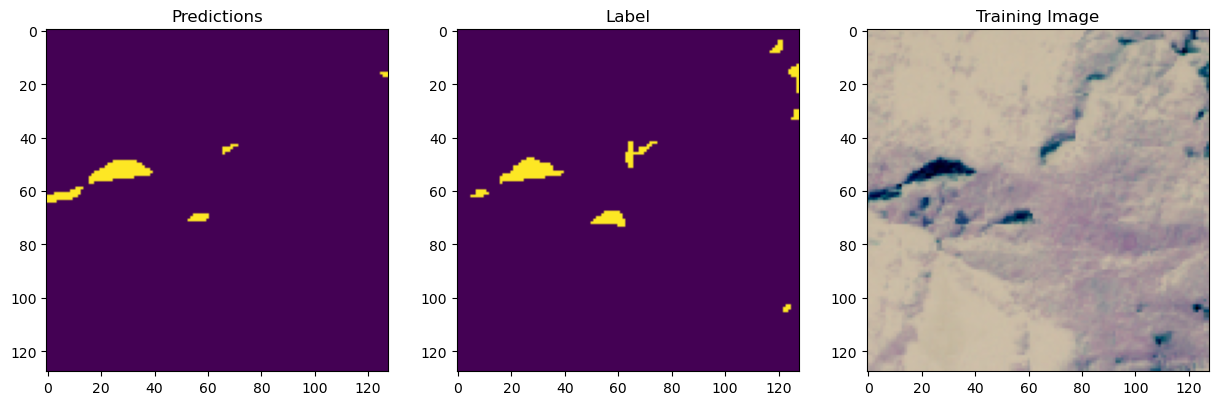

In [33]:
img = 155
fig,(ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,10))
ax1.imshow(pred_img[img, :, :, 0])
ax1.set_title("Predictions")
ax2.imshow(y_valid[img, :, :, 0])
ax2.set_title("Label")
ax3.imshow(x_valid[img, :, :, 0:3])
ax3.set_title('Training Image')

## Validation

In [ ]:
validation_url = r'/content/gdrive/MyDrive/DL/landslide4Sense/data/validation/img/*.h5'
img_val = sorted(glob.glob(validation_url))

VAL_XX = np.zeros((245, 128, 128, 6))
mask_name = []
for i, img in enumerate(img_val):
    print(i, img)
    mask_name.append(img.split('/')[-1].replace('image', 'mask'))
    with h5py.File(img) as hdf:
        ls = list(hdf.keys())
        data = np.array(hdf.get('img'))

        # assign 0 for the nan value
        data[np.isnan(data)] = 0.000001

        # to normalize the data 
        mid_rgb = data[:, :, 1:4].max() / 2.0
        mid_slope = data[:, :, 12].max() / 2.0
        mid_elevation = data[:, :, 13].max() / 2.0

        # ndvi calculation
        data_red = data[:, :, 3]
        data_nir = data[:, :, 7]
        data_ndvi = np.divide(data_nir - data_red,np.add(data_nir, data_red))
        
        # final array
        VAL_XX[i, :, :, 0] = 1 - data[:, :, 3] / mid_rgb #RED
        VAL_XX[i, :, :, 1] = 1 - data[:, :, 2] / mid_rgb #GREEN
        VAL_XX[i, :, :, 2] = 1 - data[:, :, 1] / mid_rgb #BLUE
        VAL_XX[i, :, :, 3] = data_ndvi #NDVI
        VAL_XX[i, :, :, 4] = 1- data[:, :, 13] / mid_slope #SLOPE
        VAL_XX[i, :, :, 5] = 1 - data[:, :, 13] / mid_elevation #ELEVATION

In [ ]:
threshold = 0.5
pred_img = model.predict(VAL_XX)
pred_img = (pred_img > threshold).astype(np.uint8)
pred_img.shape